## Import Libraries and Load Data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('Wholesale customers data.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None


## Exploratory Data Analysis (EDA)

### Scatterplot: MILK vs GROCERY Spending by Channel

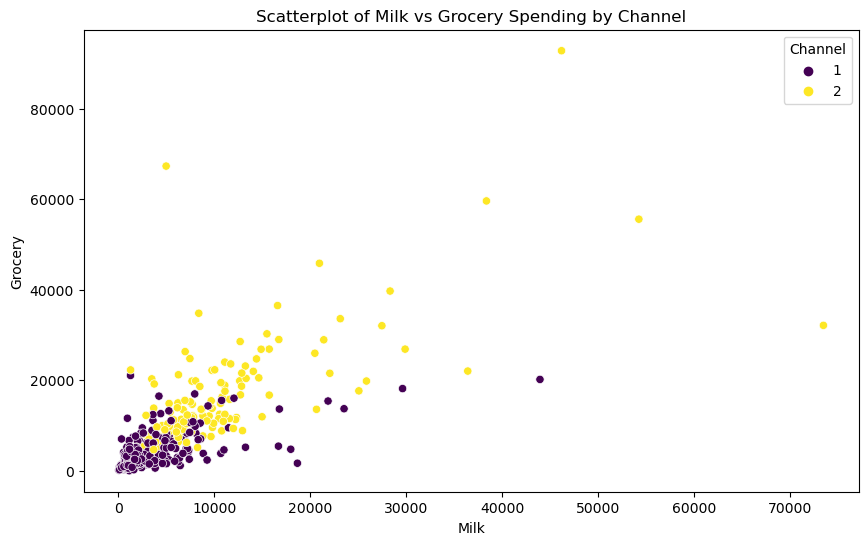

In [6]:
# Scatterplot colored by Channel
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Milk', y='Grocery', hue='Channel', palette='viridis')
plt.title('Scatterplot of Milk vs Grocery Spending by Channel')
plt.show()

### Histogram: MILK Spending by Channel

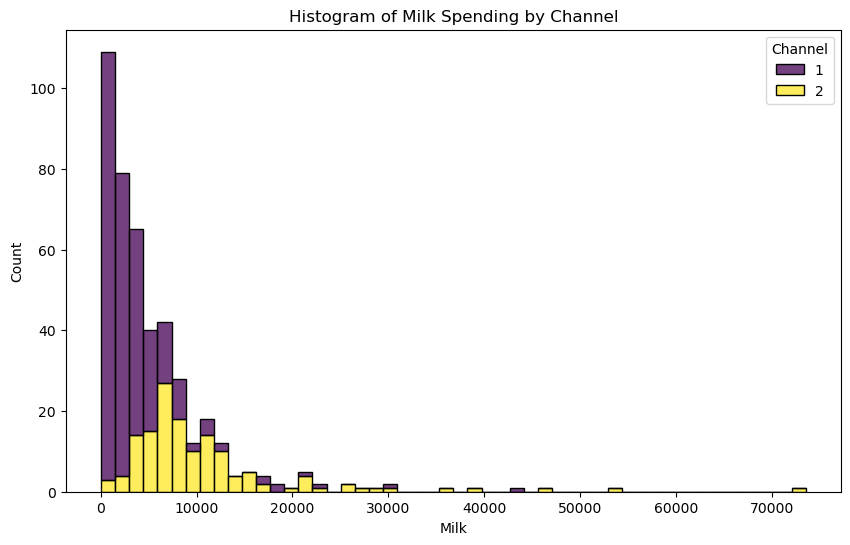

In [8]:
# Histogram of MILK spending colored by Channel using stacked bars
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='Milk', hue='Channel', multiple='stack', palette='viridis')
plt.title('Histogram of Milk Spending by Channel')
plt.show()

### Annotated Clustermap: Correlations Between Spending Categories

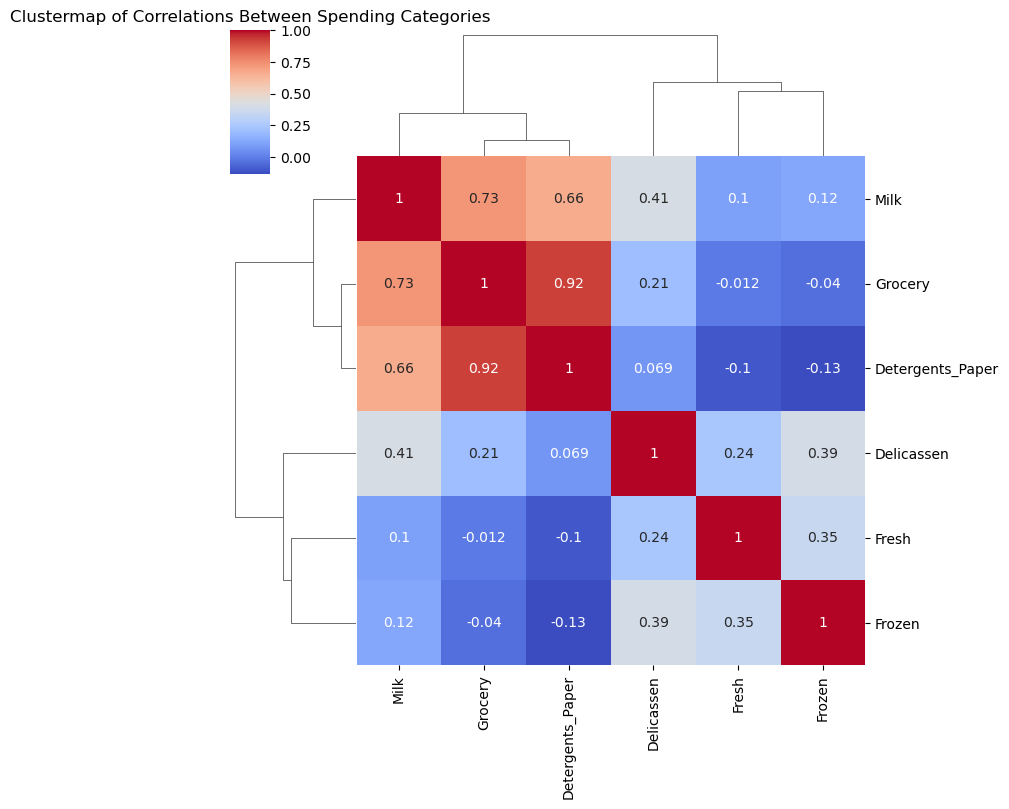

In [10]:
# Calculate correlations
corr = data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].corr()

# Create clustermap
sns.clustermap(corr, annot=True, cmap='coolwarm', figsize=(8, 8))
plt.title('Clustermap of Correlations Between Spending Categories')
plt.show()

### PairPlot: All Features Colored by Region

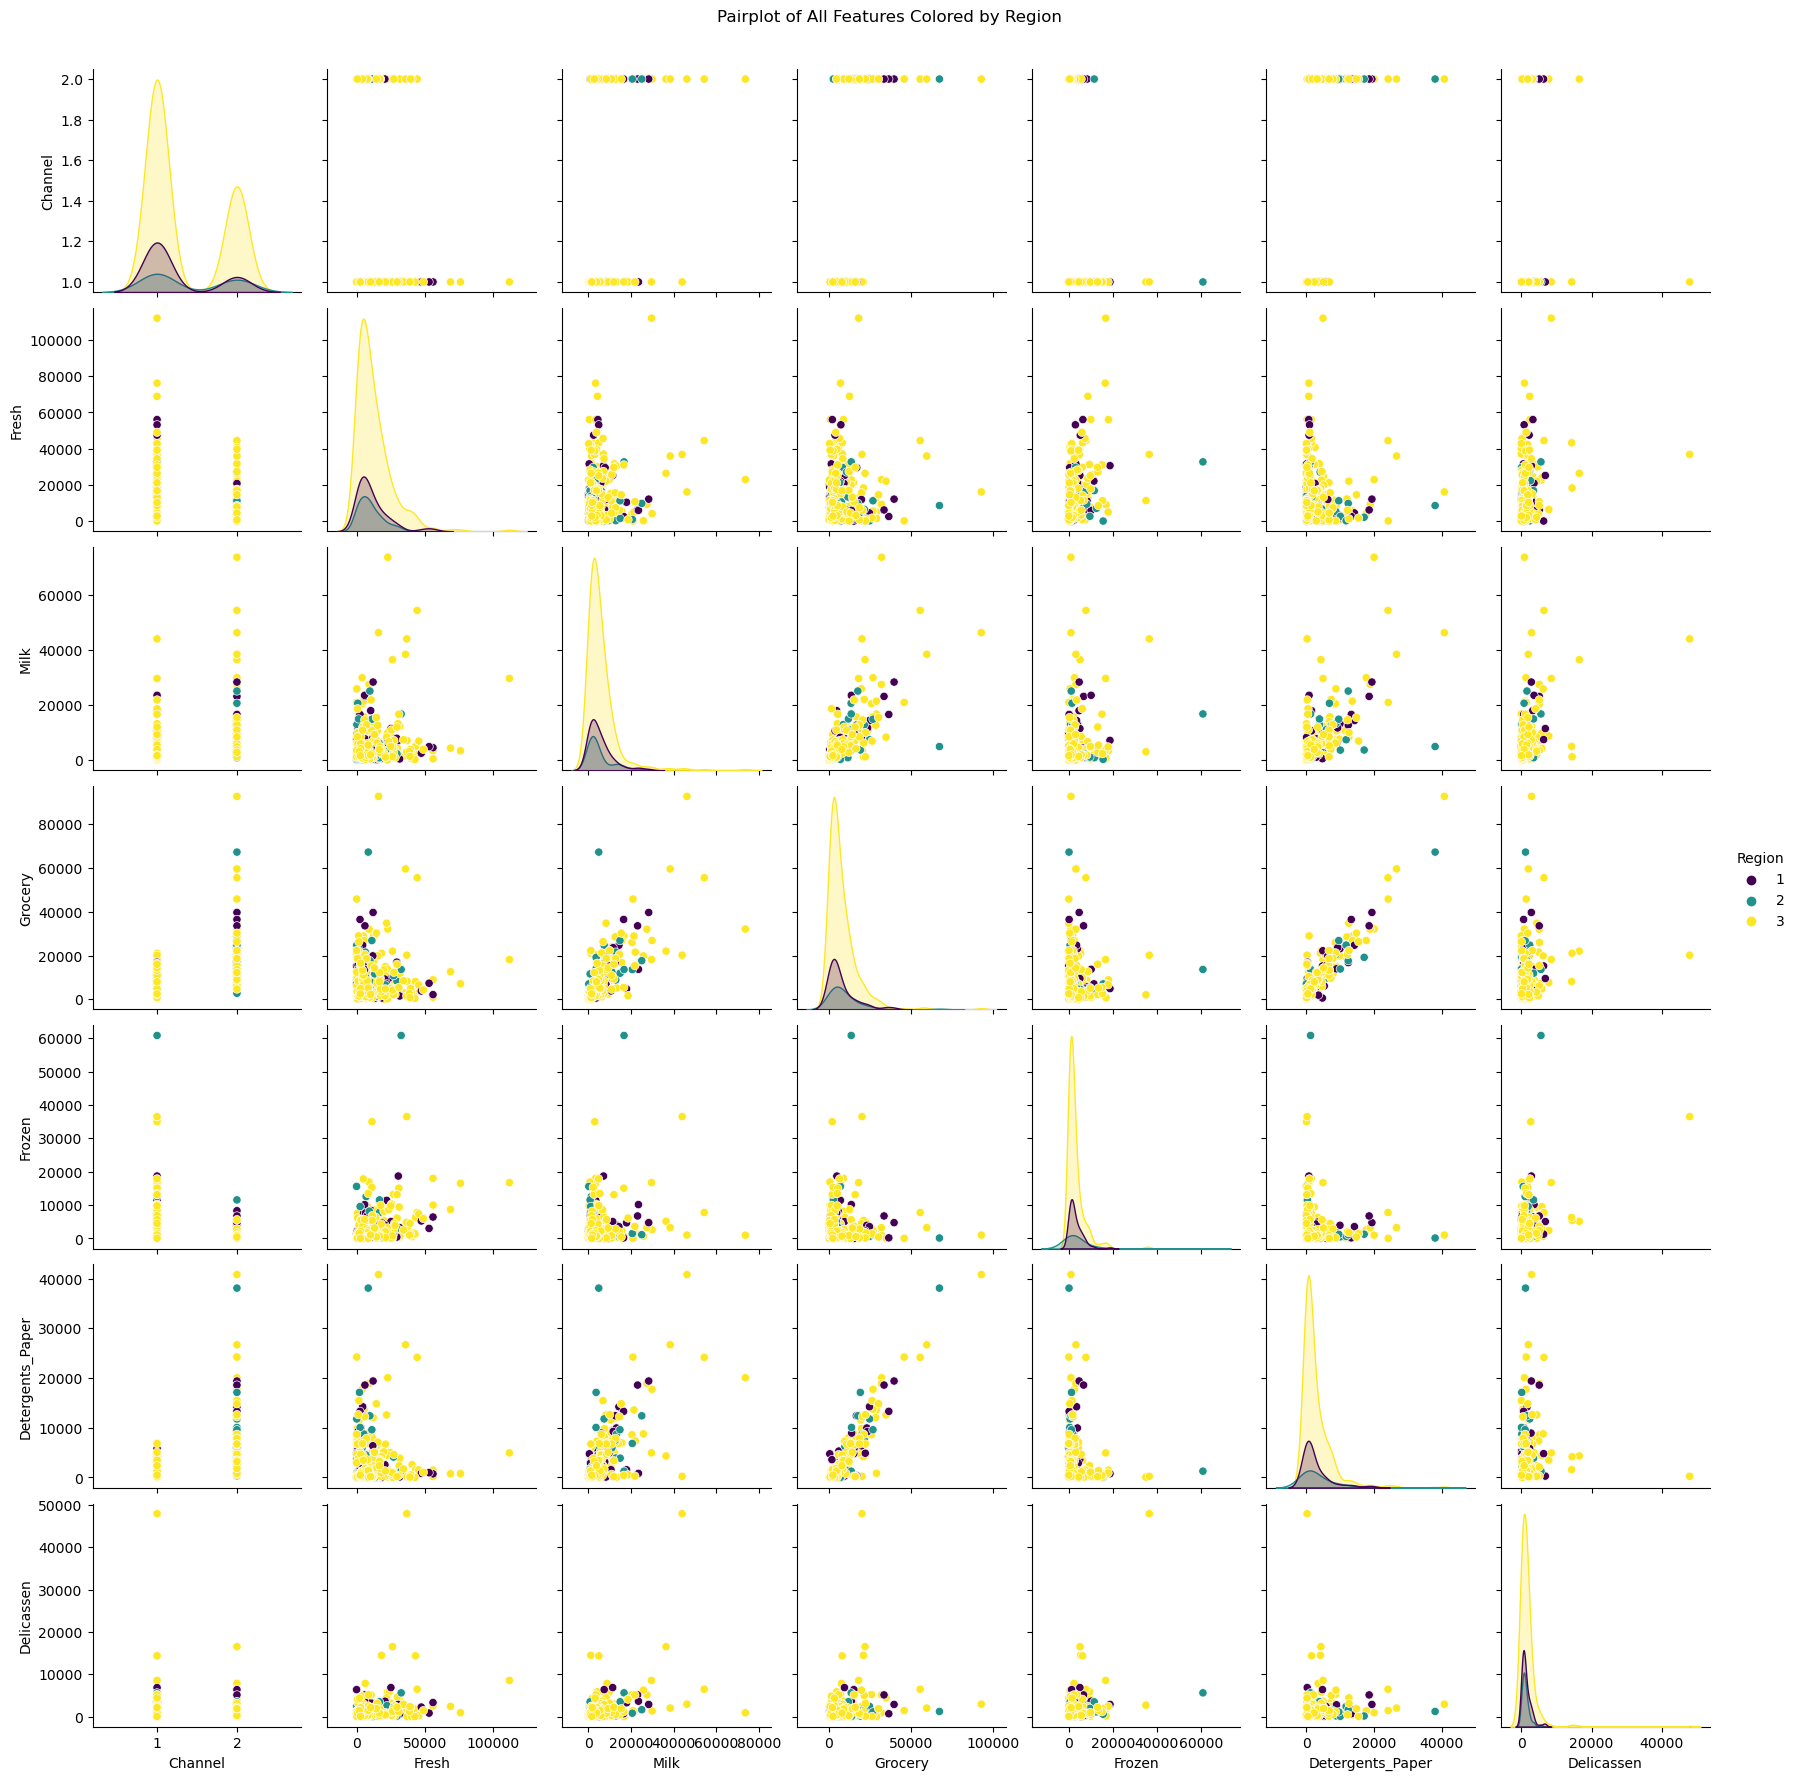

In [12]:
# Pairplot colored by Region
sns.pairplot(data, hue='Region', palette='viridis')
plt.suptitle('Pairplot of All Features Colored by Region', y=1.02)
plt.show()

## DBSCAN Clustering

### Scale the Data

In [15]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']])

# Convert scaled data back to dataframe
scaled_df = pd.DataFrame(scaled_data, columns=['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'])

### DBSCAN Over Different Epsilon Values

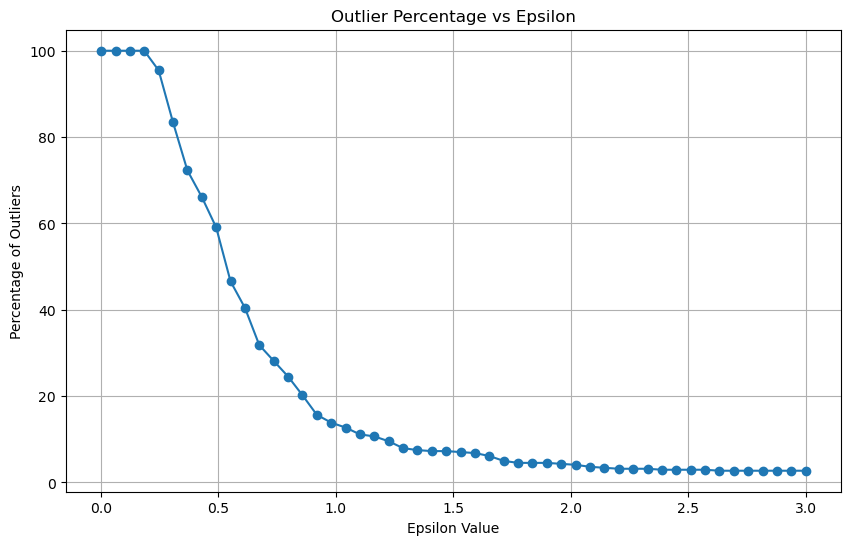

In [17]:
# Epsilon values
epsilon_values = np.linspace(0.001, 3, 50)
outliers_percentage = []

# Loop over epsilon values
for eps in epsilon_values:
    dbscan = DBSCAN(eps=eps, min_samples=2 * len(scaled_df.columns))
    labels = dbscan.fit_predict(scaled_df)
    # Percentage of points classified as outliers
    outliers_percentage.append(np.sum(labels == -1) / len(labels) * 100)

# Plot outliers percentage vs epsilon
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, outliers_percentage, marker='o')
plt.title('Outlier Percentage vs Epsilon')
plt.xlabel('Epsilon Value')
plt.ylabel('Percentage of Outliers')
plt.grid(True)
plt.show()

### Calculate Epsilon from K-Nearest Neighbors

In [19]:
# Setting parameters
k = 4  # Using 4th-nearest neighbor

# Initialize NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(scaled_df)
distances, indices = neighbors_fit.kneighbors(scaled_df)

# Use the distance to the k-th nearest neighbor
kth_distances = distances[:, k-1]

# Calculate mean and standard deviation
mean_distance = np.mean(kth_distances)
std_distance = np.std(kth_distances)

# Calculate epsilon as mean + std deviation
epsilon = mean_distance + std_distance

print(f"Calculated epsilon: {epsilon:.3f}")

Calculated epsilon: 1.830


## DBSCAN with Chosen Epsilon

### DBSCAN Retrain and Scatterplot

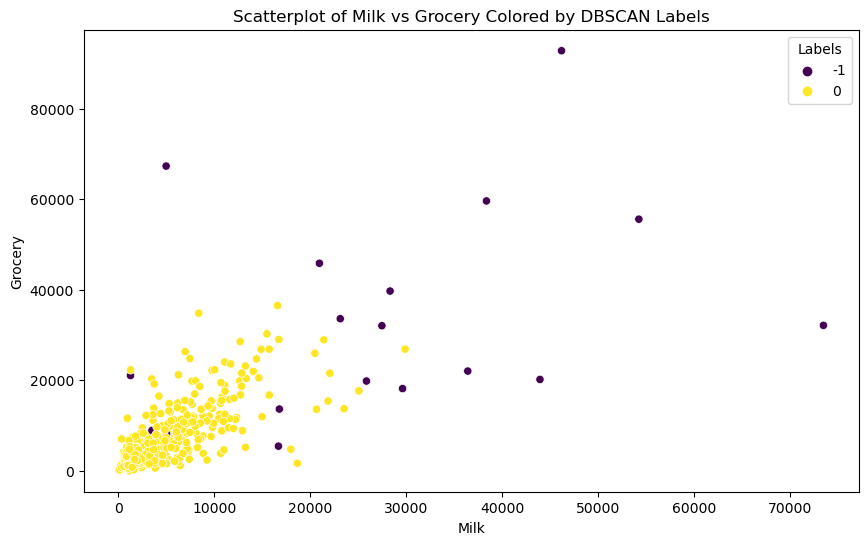

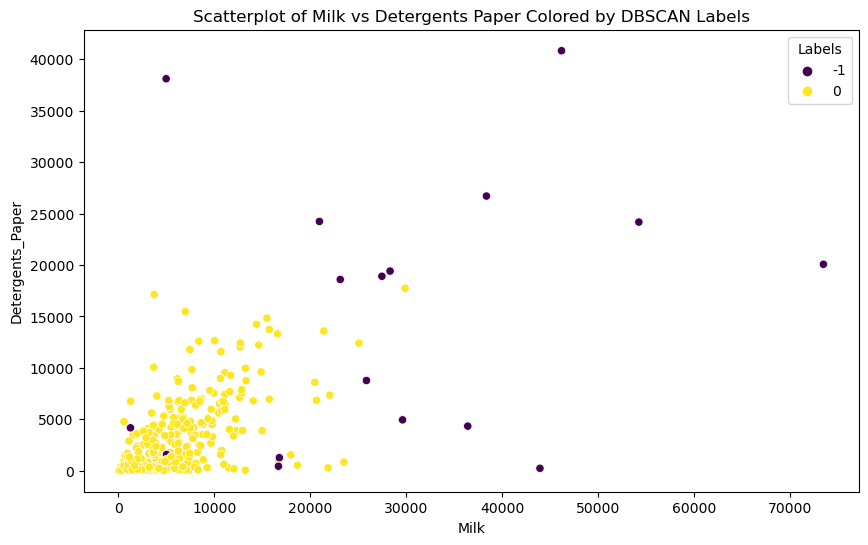

In [22]:
# Retrain DBSCAN with chosen eps
chosen_eps = 1.830
dbscan = DBSCAN(eps=chosen_eps, min_samples=2 * len(scaled_df.columns))
data['Labels'] = dbscan.fit_predict(scaled_df)

# Scatterplot of Milk vs Grocery colored by DBSCAN labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Milk', y='Grocery', hue='Labels', palette='viridis')
plt.title('Scatterplot of Milk vs Grocery Colored by DBSCAN Labels')
plt.show()

# Scatterplot of Milk vs Detergents_Paper
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Milk', y='Detergents_Paper', hue='Labels', palette='viridis')
plt.title('Scatterplot of Milk vs Detergents Paper Colored by DBSCAN Labels')
plt.show()

### Statistical Analysis of Clusters

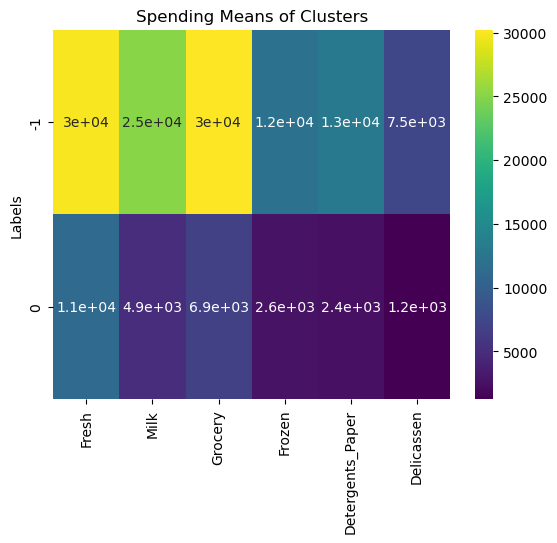

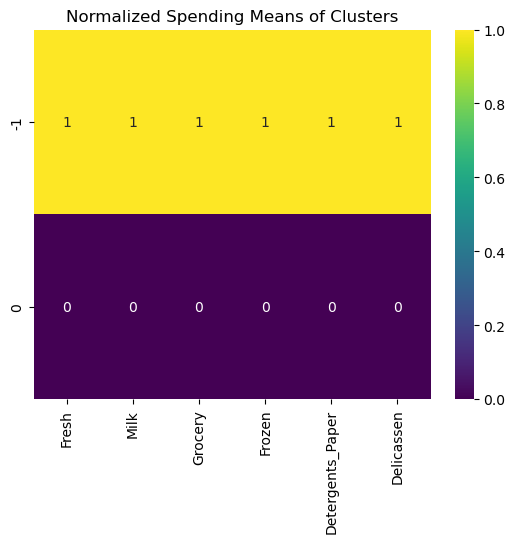

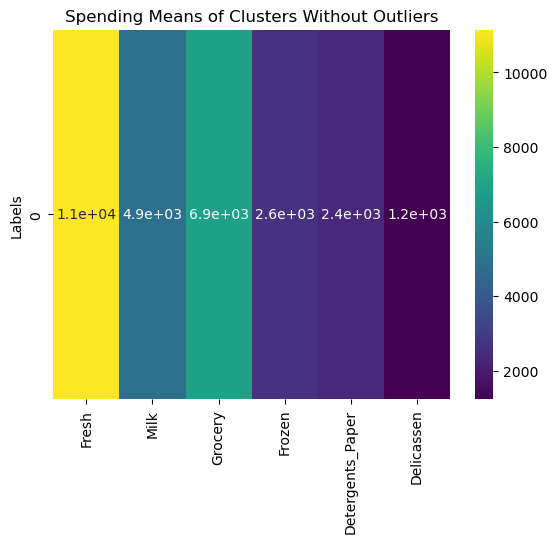

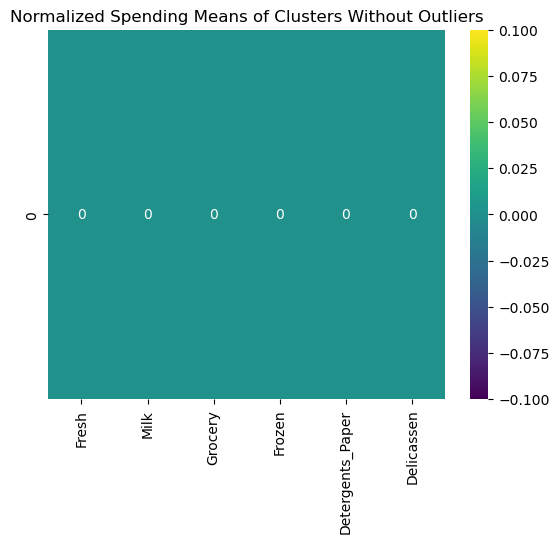

In [24]:
# Compute means for each cluster
mean_values = data.groupby('Labels')[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].mean()

# Create heatmap
sns.heatmap(mean_values, annot=True, cmap='viridis', xticklabels=mean_values.columns, yticklabels=mean_values.index)
plt.title('Spending Means of Clusters')
plt.show()

# Normalize and create heatmap
scaler = MinMaxScaler()
scaled_means = scaler.fit_transform(mean_values)
sns.heatmap(scaled_means, annot=True, cmap='viridis', xticklabels=mean_values.columns, yticklabels=mean_values.index)
plt.title('Normalized Spending Means of Clusters')
plt.show()

# Heatmap without outliers
non_outliers = mean_values.drop(index=-1)
sns.heatmap(non_outliers, annot=True, cmap='viridis', xticklabels=mean_values.columns, yticklabels=non_outliers.index)
plt.title('Spending Means of Clusters Without Outliers')
plt.show()

# Heatmap without outliers (normalized)
non_outliers = mean_values.drop(index=-1)
scaled_means_no_outliers = scaler.transform(non_outliers)
sns.heatmap(scaled_means_no_outliers, annot=True, cmap='viridis', xticklabels=mean_values.columns, yticklabels=non_outliers.index)
plt.title('Normalized Spending Means of Clusters Without Outliers')
plt.show()

The spending category with the most difference between the two clusters is: Grocery


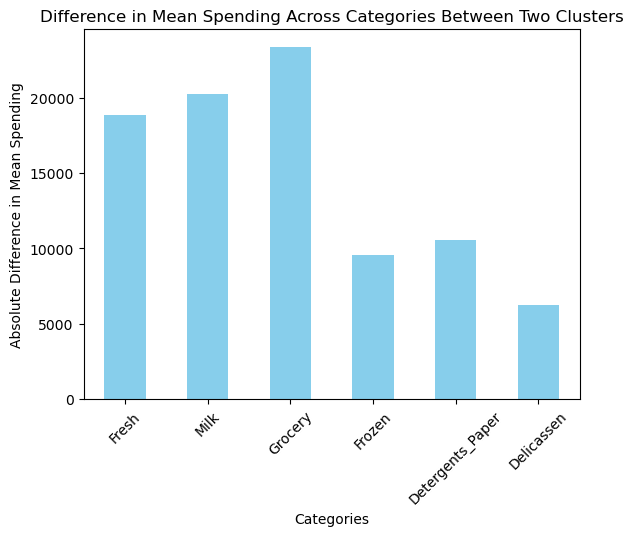

In [25]:
# Calculate absolute differences between the means of the first two clusters if they exist
if mean_values.shape[0] > 1:
    differences = abs(mean_values.iloc[0] - mean_values.iloc[1])
    most_different_category = differences.idxmax()
    print(f"The spending category with the most difference between the two clusters is: {most_different_category}")

    # Plotting differences
    differences.plot(kind='bar', color='skyblue')
    plt.title('Difference in Mean Spending Across Categories Between Two Clusters')
    plt.ylabel('Absolute Difference in Mean Spending')
    plt.xlabel('Categories')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Not enough clusters to compare.")